Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [7]:
NAME = ""
COLLABORATORS = ""

---

# RASTER OPERATIONS AND ZONAL STATISTICS 

Lab objective: 
1. learn about basic raster operations, i.e. open raster, file, see its key features
2. re-project raster 
3. Do zonal statistics 

## Rasterio
Rasterio is a major package to work with raster dataset. It opens and do basic operations of the raster. 

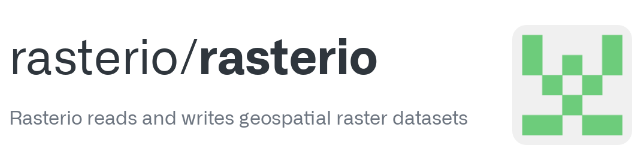   
Documentation: 
https://rasterio.readthedocs.io/en/stable/intro.html

In [8]:
import os
import rasterstats
import rasterio
import geopandas as gpd
import pandas as pd

## Open raster and see its basic properties

In [9]:
raster = rasterio.open('crop_2018_subset2.tif')

In [10]:
type(raster)

rasterio.io.DatasetReader

In [11]:
raster.crs

CRS.from_epsg(4269)

In [12]:
# raster.head()

# Let's learn about `with` statement
#### `With` statemnt - you can also use the `with` statement to make things look a bit neat and clean

Without with statement, the code to open a file is like this:

file = open('file_path', 'w')   
file.write('hello world !')   
file.close()   
    
You have to call df in each line. Using with statement,     
#### using `with` statement    
with open('file_path', 'w') as file      :
    file.write('hello world !   
   
https://www.geeksforgeeks.org/with-statement-in-python/')

In [13]:
with rasterio.open('crop_2018_subset2.tif') as raster_crop:
    crop_val = raster_crop.read()
crop_val

array([[[255, 255, 255, ..., 255, 255, 255],
        [176, 176, 176, ..., 255, 255, 255],
        [176, 176, 176, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

# Reproject in raster 
Reprojection is a multi-step process and not as simple as vector re-projection. 

Followed this reference: 
https://rasterio.readthedocs.io/en/stable/topics/reproject.html#estimating-optimal-output-shape

Basically for reprojection, you will need to set up their spatial extent (boundary) and update the metadata

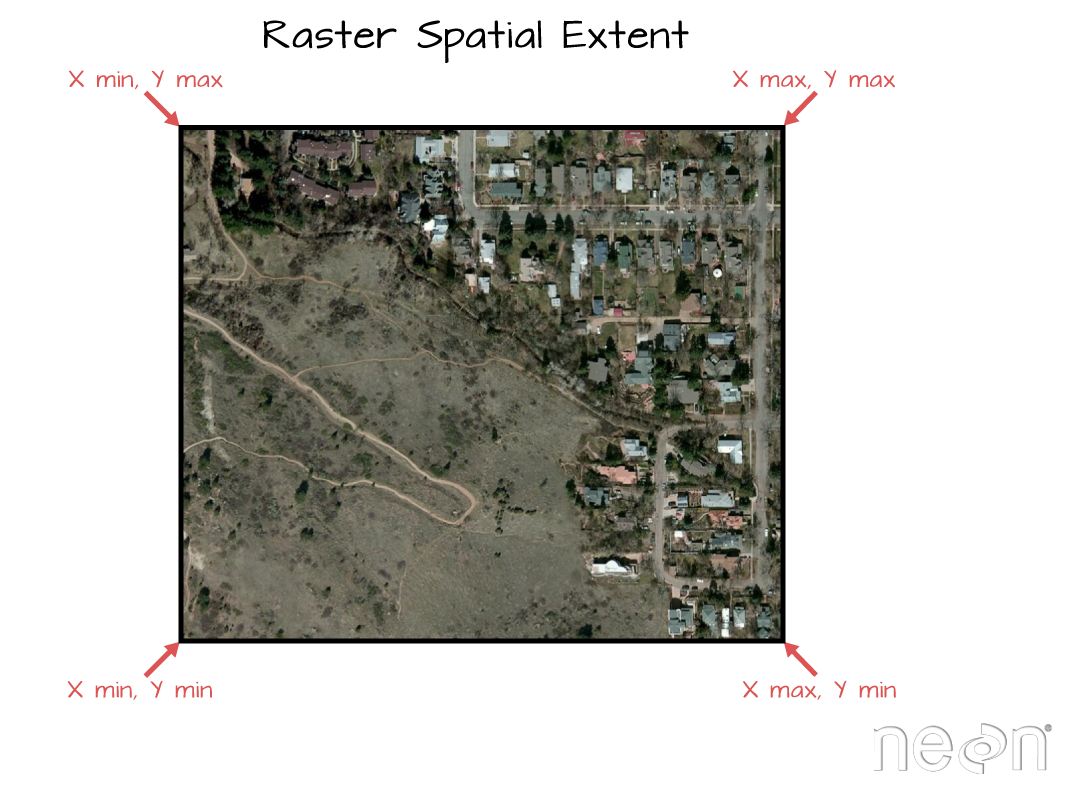  

Source: https://www.neonscience.org/resources/learning-hub/tutorials/dc-raster-data-r


In [14]:
# Packages 
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [15]:
# Spatial extent of raster data
raster.bounds

BoundingBox(left=-96.3026889043428, bottom=36.96925375632969, right=-94.30723249295608, top=38.0592680012633)

In [16]:
# Raster resolution 
print(raster.crs.linear_units)

unknown


In [17]:
dst_crs = 'EPSG:9712'

# step 1: Calculate transform array and shape of reprojected raster 
with rasterio.open('crop_2018_subset2.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # step 2: We copy metadata from source dataset to dictionary object `kwargs`
    # step 3: we update information in kwargs object with destination crs 
    kwargs = src.meta.copy()
    kwargs.update({
    'crs': dst_crs,
    'transform': transform, 
    'width': width, 
    'height': height
    })

    # step 4: for each band (i), we reproject the calculated parameters froms source to destination      
    with rasterio.open('crop_2018_subset2_pr.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count +1):
            reproject(
                source = rasterio.band(src, i), 
                destination = rasterio.band(dst, i), 
                src_transform = src.transform, 
                src_crs = src.crs, 
                dst_transform = transform, 
                dst_crs = dst_crs, 
                resampling = Resampling.nearest)
    # make sure to close the raster file
        dst.close()

In [18]:
raster = rasterio.open('crop_2018_subset2_pr.tif')

In [19]:
print(raster.crs)
print(raster.crs.linear_units)

EPSG:9712
metre


### Display the raster map

In [20]:
from rasterio.plot import show
from rasterio.plot import show_hist

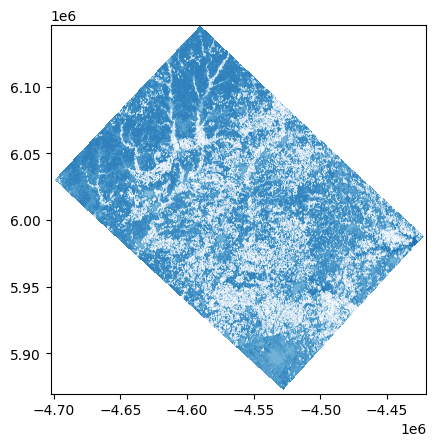

<Axes: >

In [21]:
# 1 = layer 1, 
show(raster,1, cmap = 'Blues')

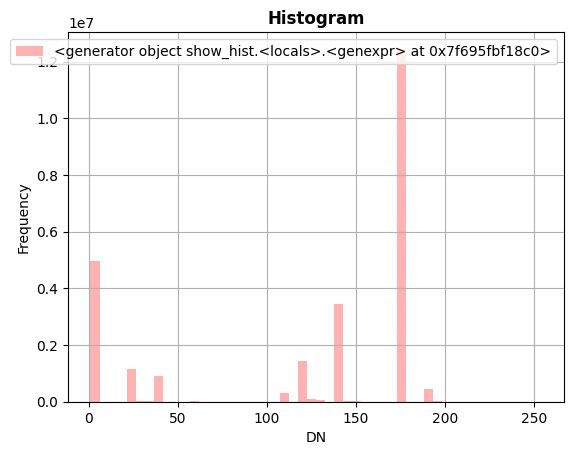

In [22]:
show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Histogram")

# zonal stat module from rasterstats
#### Documentation - https://pythonhosted.org/rasterstats/

In [23]:
from rasterstats import zonal_stats

In [24]:
raster = rasterio.open('crop_2018_subset2_pr.tif')

In [25]:
raster.crs

CRS.from_epsg(9712)

In [26]:
shp = gpd.read_file('counties_subset3.shp')

In [27]:
print(shp.crs)

EPSG:4269


### Change vector CRS 

In [28]:
# We want to convert it to something in meter. NAD is good for location measurement in the USA.  
shp = shp.to_crs(9712)

In [29]:
shp.crs

<Projected CRS: EPSG:9712>
Name: NAD83 / UTM zone 24N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada offshore Atlantic - east of 42°W.
- bounds: (-42.0, 45.53, -40.73, 49.53)
Coordinate Operation:
- name: UTM zone 24N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
shp.head(13)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,20,001,00484970,0500000US20001,20001,Allen,06,1295763786,13022381,"POLYGON ((-4555842.909 6050607.349, -4554363.7..."
1,20,037,00484988,0500000US20037,20037,Crawford,06,1527498199,13574680,"POLYGON ((-4537010.618 5995421.646, -4536646.7..."
2,20,125,00485027,0500000US20125,20125,Montgomery,06,1666900068,20430024,"POLYGON ((-4662640.981 6012119.663, -4659722.7..."
3,20,021,00484980,0500000US20021,20021,Cherokee,06,1521791027,8951473,"POLYGON ((-4557486.646 5970521.353, -4550483.3..."
4,20,205,00485063,0500000US20205,20205,Wilson,06,1477382268,12052249,"POLYGON ((-4626861.066 6050091.322, -4626214.5..."
5,20,133,00485030,0500000US20133,20133,Neosho,06,1480111173,16369480,"POLYGON ((-4566121.219 6039646.271, -4564650.4..."
6,20,207,00485064,0500000US20207,20207,Woodson,06,1289344336,19254559,"POLYGON ((-4585637.449 6093661.557, -4585362.8..."
7,20,011,00484975,0500000US20011,20011,Bourbon,06,1645861890,9377600,"POLYGON ((-4519700.691 6014344.537, -4516810.5..."
8,20,099,00485014,0500000US20099,20099,Labette,06,1671560462,20006432,"POLYGON ((-4624273.296 5975909.365, -4622841.2..."


## Zonal Statistics Calculation   
https://pythonhosted.org/rasterstats/ 

In [31]:
zonal_stats(shp, "crop_2018_subset2_pr.tif", stats = "sum")

[{'sum': 165271926.0},
 {'sum': 202429055.0},
 {'sum': 258487122.0},
 {'sum': 172464419.0},
 {'sum': 198833874.0},
 {'sum': 207449973.0},
 {'sum': 206797517.0},
 {'sum': 262187534.0},
 {'sum': 233837757.0}]

##### Interpretation of the result above:      

We are getting the summation of all the crops for nine counties which is not what we are looking for.   


We want to get a table like this which has GEOID, crop_value, sum of cell (which gives us area) 

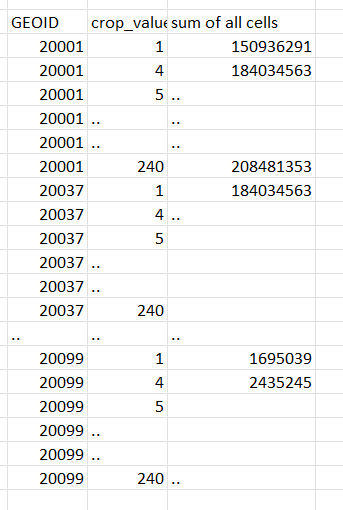

#### Add category to the zonal statistics table 
https://pythonhosted.org/rasterstats/ 


In [32]:
zonal_stats( shp, "crop_2018_subset2_pr.tif", categorical = True, stats = "sum")

[{1: 148284,
  2: 3,
  4: 979,
  5: 332338,
  6: 9,
  21: 210,
  24: 5157,
  26: 32360,
  27: 89,
  28: 1798,
  31: 2,
  36: 3306,
  37: 73117,
  44: 424,
  58: 969,
  59: 7,
  61: 92,
  74: 9,
  111: 13540,
  121: 71288,
  122: 20781,
  123: 4401,
  124: 1234,
  131: 2843,
  141: 151890,
  142: 20,
  143: 2644,
  152: 120,
  176: 696868,
  190: 6426,
  195: 419,
  205: 6,
  236: 32,
  238: 2,
  240: 94,
  'sum': 165271926.0},
 {1: 222878,
  2: 1,
  4: 382,
  5: 281642,
  6: 13,
  21: 27,
  24: 3808,
  26: 65382,
  27: 1,
  28: 433,
  36: 3085,
  37: 74577,
  44: 150,
  58: 444,
  59: 207,
  61: 35,
  74: 84,
  111: 26486,
  121: 91516,
  122: 35016,
  123: 8025,
  124: 2486,
  131: 3245,
  141: 182484,
  142: 45,
  143: 375,
  152: 625,
  176: 772823,
  190: 72878,
  195: 1008,
  205: 7,
  225: 2,
  236: 16,
  238: 2,
  240: 465,
  'sum': 202429055.0},
 {1: 140935,
  2: 13,
  4: 1506,
  5: 180543,
  6: 47,
  21: 31,
  24: 11592,
  26: 134428,
  27: 4,
  28: 328,
  29: 1,
  36: 3165,
 

### How to convert this list into this a data frame?

There are two ways to add items:   
1. append: add the items at the bottom of the row
2. insert: add columns 

In [40]:
crop_count = pd.DataFrame(zonal_stats(shp, "crop_2018_subset2_pr.tif", categorical = True, stats = "sum"))

In [41]:
crop_count.head(12)

,1,2,4,5,6,21,24,26,27,28,...,195,205,236,238,240,sum,225,29,241,254
0,148284,3.0,979,332338,9.0,210,5157,32360,89.0,1798,...,419,6.0,32,2.0,94.0,165271926.0,NaN,NaN,NaN,NaN
1,222878,1.0,382,281642,13.0,27,3808,65382,1.0,433,...,1008,7.0,16,2.0,465.0,202429055.0,2.0,NaN,NaN,NaN
2,140935,13.0,1506,180543,47.0,31,11592,134428,4.0,328,...,2275,NaN,53,NaN,21.0,258487122.0,6.0,1.0,NaN,NaN
3,313455,NaN,457,241513,14.0,48,2324,228184,1.0,160,...,2675,132.0,124,7.0,431.0,172464419.0,2.0,34.0,64.0,NaN
4,205608,2.0,381,240221,23.0,9,8791,144368,11.0,433,...,818,4.0,101,NaN,NaN,198833874.0,133.0,NaN,NaN,NaN
5,192455,2.0,1388,212820,1.0,150,13133,71534,162.0,1667,...,1016,10.0,20,NaN,996.0,207449973.0,2.0,3.0,NaN,13.0
6,98746,NaN,1622,175097,28.0,1,6181,31564,29.0,560,...,406,34.0,40,NaN,16.0,206797517.0,2.0,NaN,NaN,NaN
7,91083,NaN,1002,171649,NaN,14,2563,10876,NaN,226,...,698,142.0,13,NaN,101.0,262187534.0,NaN,NaN,NaN,NaN
8,223598,7.0,1156,216708,13.0,261,9190,155037,2.0,819,...,1358,6.0,54,NaN,421.0,233837757.0,19.0,6.0,NaN,NaN


In [42]:
shp.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,20,001,00484970,0500000US20001,20001,Allen,06,1295763786,13022381,"POLYGON ((-4555842.909 6050607.349, -4554363.7..."
1,20,037,00484988,0500000US20037,20037,Crawford,06,1527498199,13574680,"POLYGON ((-4537010.618 5995421.646, -4536646.7..."
2,20,125,00485027,0500000US20125,20125,Montgomery,06,1666900068,20430024,"POLYGON ((-4662640.981 6012119.663, -4659722.7..."
3,20,021,00484980,0500000US20021,20021,Cherokee,06,1521791027,8951473,"POLYGON ((-4557486.646 5970521.353, -4550483.3..."
4,20,205,00485063,0500000US20205,20205,Wilson,06,1477382268,12052249,"POLYGON ((-4626861.066 6050091.322, -4626214.5..."


In [36]:
geoid = pd.DataFrame(shp.iloc[:,4])

In [37]:
geoid.head(10)

,GEOID
0,20001
1,20037
2,20125
3,20021
4,20205
5,20133
6,20207
7,20011
8,20099


In [38]:
# combine the two data frames
crop_count1 = pd.concat([geoid, crop_count], axis=1, join='inner')

In [39]:
crop_count1.head(10)

,GEOID,1,2,4,5,6,21,24,26,27,...,195,205,236,238,240,sum,225,29,241,254
0,20001,148284,3.0,979,332338,9.0,210,5157,32360,89.0,...,419,6.0,32,2.0,94.0,165271926.0,NaN,NaN,NaN,NaN
1,20037,222878,1.0,382,281642,13.0,27,3808,65382,1.0,...,1008,7.0,16,2.0,465.0,202429055.0,2.0,NaN,NaN,NaN
2,20125,140935,13.0,1506,180543,47.0,31,11592,134428,4.0,...,2275,NaN,53,NaN,21.0,258487122.0,6.0,1.0,NaN,NaN
3,20021,313455,NaN,457,241513,14.0,48,2324,228184,1.0,...,2675,132.0,124,7.0,431.0,172464419.0,2.0,34.0,64.0,NaN
4,20205,205608,2.0,381,240221,23.0,9,8791,144368,11.0,...,818,4.0,101,NaN,NaN,198833874.0,133.0,NaN,NaN,NaN
5,20133,192455,2.0,1388,212820,1.0,150,13133,71534,162.0,...,1016,10.0,20,NaN,996.0,207449973.0,2.0,3.0,NaN,13.0
6,20207,98746,NaN,1622,175097,28.0,1,6181,31564,29.0,...,406,34.0,40,NaN,16.0,206797517.0,2.0,NaN,NaN,NaN
7,20011,91083,NaN,1002,171649,NaN,14,2563,10876,NaN,...,698,142.0,13,NaN,101.0,262187534.0,NaN,NaN,NaN,NaN
8,20099,223598,7.0,1156,216708,13.0,261,9190,155037,2.0,...,1358,6.0,54,NaN,421.0,233837757.0,19.0,6.0,NaN,NaN
